# **Title**: Nvidia Kaggle Compition # 


**Author : Jasmeen Sameer Shaikh**

**Github** : [Jasmeen Guithub ID](http://github.com/jass2422)


**LinkedIn:**[Jasmeen LinkedIn ID](http://www.linkedin.com/in/jasmeen-shaikh-075b35240/)

 
***In computer vision tasks, it's essential to visually inspect the dataset to ensure that the images are correctly loaded, transformed, and labeled. The following code defines a visualize_batch function that helps in visualizing a batch of images from the DataLoader. This function supports both labeled datasets (like training and validation sets) and unlabeled datasets (like the test set). It also handles the denormalization of image tensors for accurate and human-friendly display. By displaying a few samples from each split (train, validation, and test), we can verify the effectiveness of our data preprocessing and transformations.***


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fruit-classification/sample_submission.csv
/kaggle/input/fruit-classification/train.csv
/kaggle/input/fruit-classification/test/test/test_398.png
/kaggle/input/fruit-classification/test/test/test_12.png
/kaggle/input/fruit-classification/test/test/test_173.png
/kaggle/input/fruit-classification/test/test/test_277.png
/kaggle/input/fruit-classification/test/test/test_116.png
/kaggle/input/fruit-classification/test/test/test_360.png
/kaggle/input/fruit-classification/test/test/test_334.png
/kaggle/input/fruit-classification/test/test/test_102.png
/kaggle/input/fruit-classification/test/test/test_304.png
/kaggle/input/fruit-classification/test/test/test_354.png
/kaggle/input/fruit-classification/test/test/test_127.png
/kaggle/input/fruit-classification/test/test/test_46.png
/kaggle/input/fruit-classification/test/test/test_429.png
/kaggle/input/fruit-classification/test/test/test_126.png
/kaggle/input/fruit-classification/test/test/test_100.png
/kaggle/input/fruit-classifica

In [2]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
TRAIN_CSV_PATH = '/kaggle/input/fruit-classification/train.csv'
TRAIN_IMG_DIR = '/kaggle/input/fruit-classification/train/train'
TEST_IMG_DIR = '/kaggle/input/fruit-classification/test/test'
BATCH_SIZE = 32
SEED = 42
VALIDATION_SPLIT = 0.2

In [4]:
torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
# Define the transformation pipeline
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Class for the training and validation datasets (with labels)
class FruitDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        # Create a label mapping for classification
        self.classes = ['fresh_apple', 'fresh_banana', 'fresh_orange', 
                        'rotten_apple', 'rotten_banana', 'rotten_orange']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Id']
        label = self.df.iloc[idx]['Label']
        img_path = os.path.join(self.img_dir, img_name)
        
        # Handle both PNG and JPEG files with RGBA
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        # Convert text label to numeric index
        label_idx = self.class_to_idx[label]
        
        return image, label_idx

In [7]:
# Class for the test dataset (without labels)
class TestFruitDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        
        # Handle both PNG and JPEG files with RGBA
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, img_name  # Return image name as identifier instead of label

def create_dataloaders():
    # Read the training data CSV
    train_df = pd.read_csv(TRAIN_CSV_PATH)
    
    # Split into train and validation sets
    train_df, val_df = train_test_split(
        train_df, test_size=VALIDATION_SPLIT, random_state=SEED, 
        stratify=train_df['Label']  # Stratify to maintain class distribution
    )
    # Create datasets
    train_dataset = FruitDataset(train_df, TRAIN_IMG_DIR, transform=train_transforms)
    val_dataset = FruitDataset(val_df, TRAIN_IMG_DIR, transform=val_test_transforms)
    test_dataset = TestFruitDataset(TEST_IMG_DIR, transform=val_test_transforms)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
    )
    
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
    )
    
    return train_loader, val_loader, test_loader, train_dataset.classes

# Function to visualize a batch of images
def visualize_batch(dataloader, classes=None, n=8):
    images, labels = next(iter(dataloader))
    images = images[:n]  # Take only n images
    
    # Move to CPU and convert to numpy for visualization
    images = images.cpu().numpy()
    
    # Denormalize images for better visualization
    images = np.transpose(images, (0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    # Plot images in a grid
    fig, axes = plt.subplots(2, n//2, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img)
        if classes and isinstance(labels, torch.Tensor):
            ax.set_title(f"Label: {classes[labels[i].item()]}")
        elif not isinstance(labels, torch.Tensor):
            # For test datasets where labels are filenames
            ax.set_title(f"File: {labels[i]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    


In [8]:
train_loader, val_loader, test_loader, classes = create_dataloaders()

In [9]:
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")
print(f"Classes: {classes}")

Number of training batches: 27
Number of validation batches: 7
Number of test batches: 15
Classes: ['fresh_apple', 'fresh_banana', 'fresh_orange', 'rotten_apple', 'rotten_banana', 'rotten_orange']


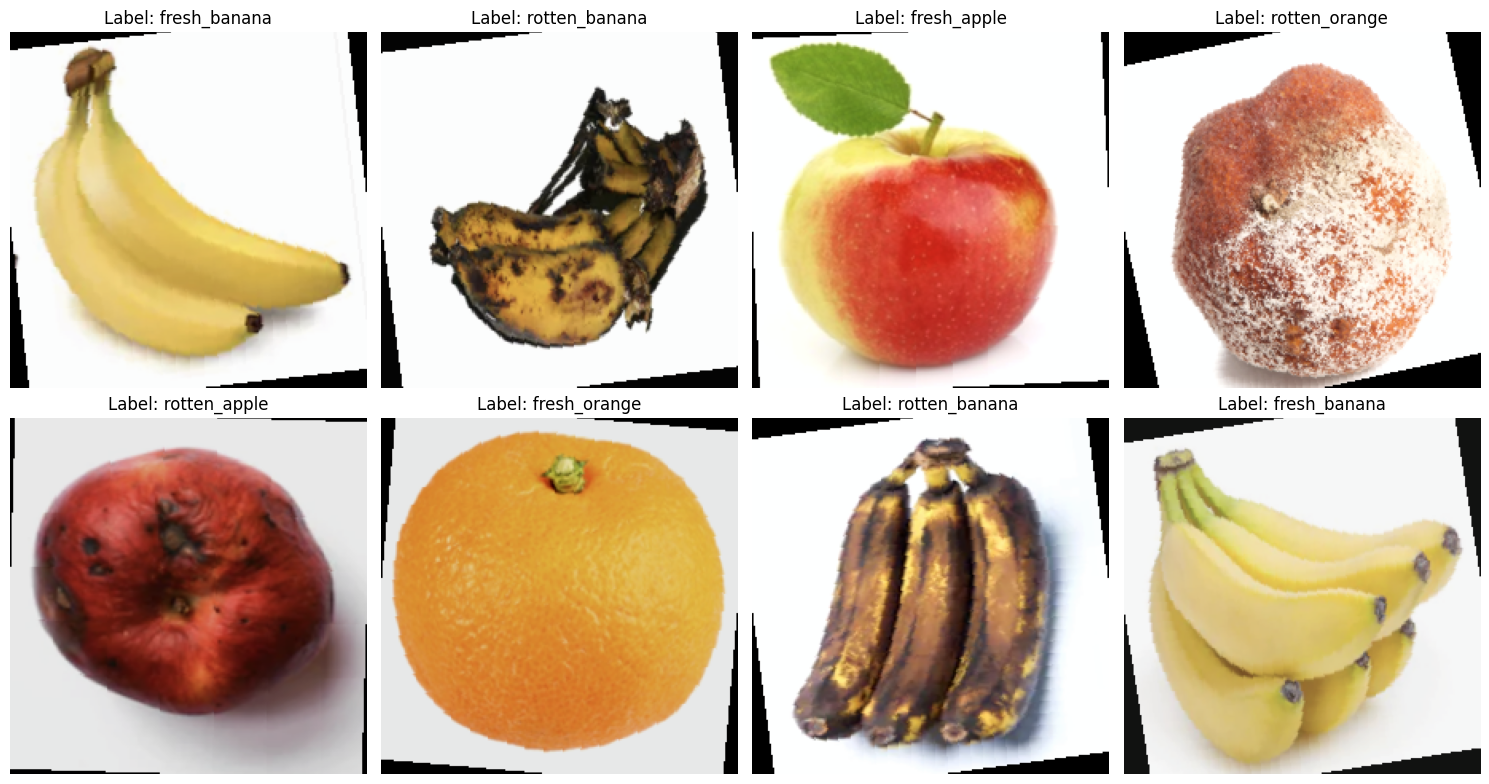

In [10]:
# # Visualize a batch from the train_loader
visualize_batch(train_loader, classes)  # Training samples with augmentation

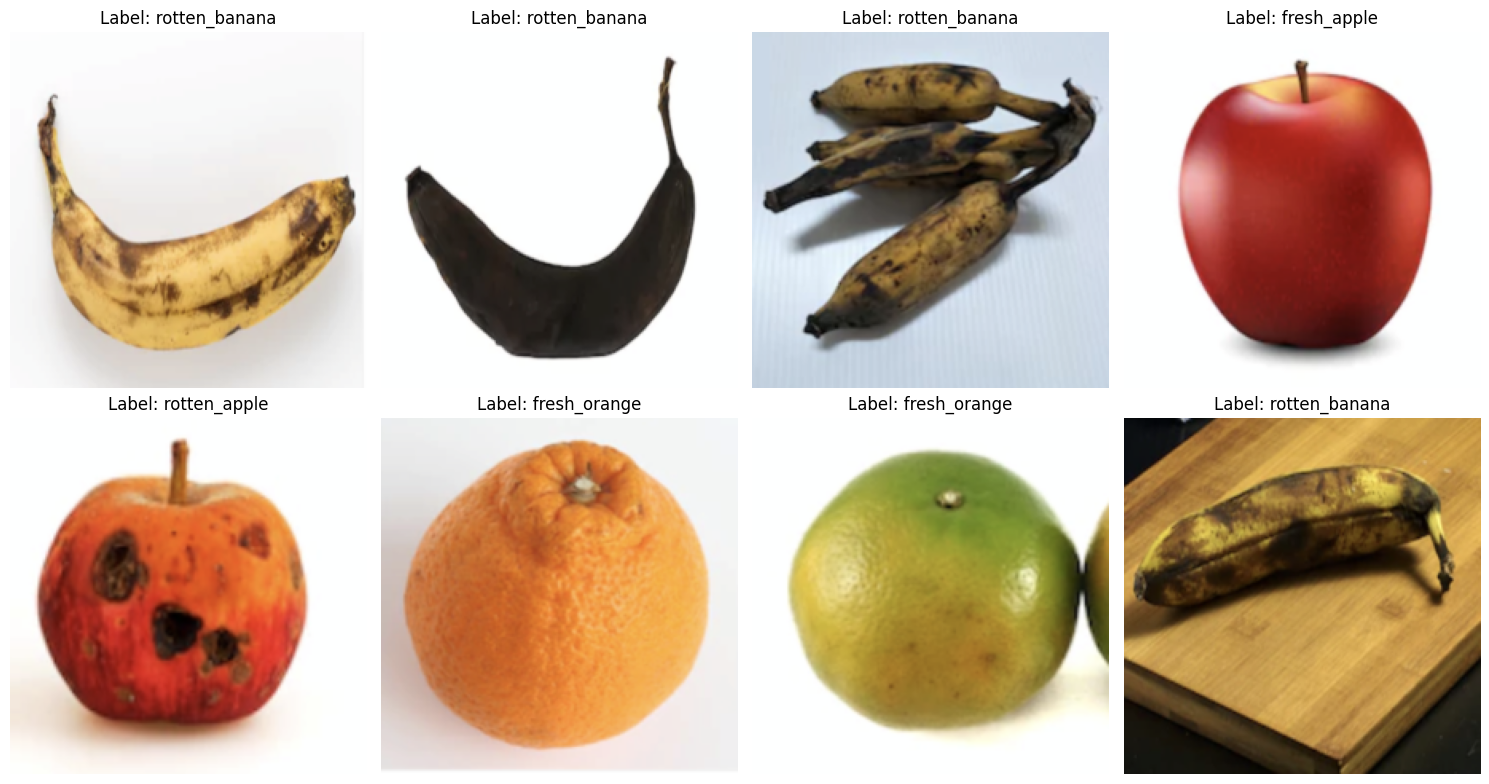

In [11]:
visualize_batch(val_loader, classes)  # Validation samples, no augmentation

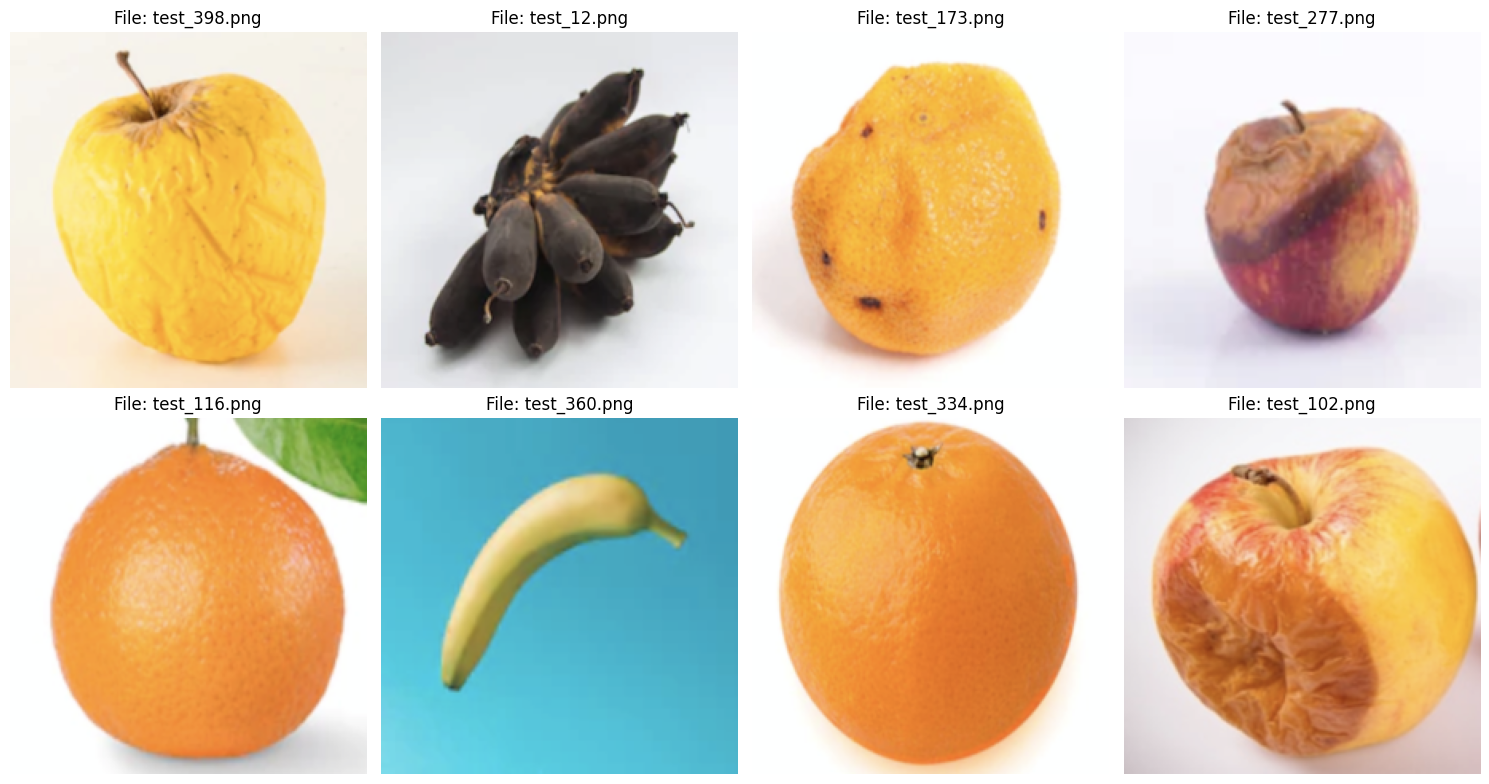

In [12]:
visualize_batch(test_loader, classes)  # Test samples, no augmentation


**Training Loop Iterating through train_loader, backpropagating loss, and updating weights.Validation Loop Evaluating the model on val_loader and calculating accuracy:**


In [13]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet18 and modify final layer
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {avg_loss:.4f}")

        # Validation Accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        print(f"Validation Accuracy: {val_acc:.2f}%\n")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=25)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 221MB/s]


Epoch 1/25 - Training Loss: 0.4979
Validation Accuracy: 95.75%

Epoch 2/25 - Training Loss: 0.0783
Validation Accuracy: 98.58%

Epoch 3/25 - Training Loss: 0.0441
Validation Accuracy: 99.06%

Epoch 4/25 - Training Loss: 0.0297
Validation Accuracy: 98.58%

Epoch 5/25 - Training Loss: 0.0286
Validation Accuracy: 99.53%

Epoch 6/25 - Training Loss: 0.0240
Validation Accuracy: 99.06%

Epoch 7/25 - Training Loss: 0.0117
Validation Accuracy: 97.64%

Epoch 8/25 - Training Loss: 0.0120
Validation Accuracy: 98.58%

Epoch 9/25 - Training Loss: 0.0334
Validation Accuracy: 97.64%

Epoch 10/25 - Training Loss: 0.0624
Validation Accuracy: 97.64%

Epoch 11/25 - Training Loss: 0.0264
Validation Accuracy: 99.06%

Epoch 12/25 - Training Loss: 0.0176
Validation Accuracy: 98.11%

Epoch 13/25 - Training Loss: 0.0153
Validation Accuracy: 97.17%

Epoch 14/25 - Training Loss: 0.0196
Validation Accuracy: 98.11%

Epoch 15/25 - Training Loss: 0.0253
Validation Accuracy: 98.58%

Epoch 16/25 - Training Loss: 0.010

# Conclusion:

**By visualizing batches from the training, validation, and test datasets, we gain valuable insights into how the model will perceive the input data. It helps confirm that the data augmentation strategies are being applied as intended and ensures there are no anomalies like incorrect labels or unreadable images. This step, though simple, plays a crucial role in the early stages of building a robust image classification pipeline.Hence , its giving (more then) >92% accuracy of the dataset**



